# Football video image classification

## For each play, classify into 3 formations (doubles,reo, empty)

## Sample a frame from the video between 1s to 3s as the input to the model

## Step 1. Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
import tensorflow_hub as hub
# suppress the warning messages
tf.get_logger().setLevel('ERROR')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

import pathlib

2022-12-29 20:17:33.646579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 2. Download and explore the dataset

This tutorial uses a dataset of about ___ photos of football play images. The dataset contains two sub-directories, one per class:

```
football/
      DoublesPictures/
      EmptyPictures/
      ReoPictures/

```

In [3]:
print("Number of frames in each categories: ")
cnt_dir={}
for x in ['DoublesPictures', 'ReoPictures', 'EmptyPictures']:
    dir_path = '../football/' + x
    cnt_dir[x] = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
    print(x, ' : ', cnt_dir[x])
          
total = 0 
for x in ['DoublesPictures', 'ReoPictures', 'EmptyPictures']:
    total += cnt_dir[x]
print(f"\nTotal images {total}")

Number of frames in each categories: 
DoublesPictures  :  812
ReoPictures  :  960
EmptyPictures  :  224

Total images 1996


#### Visualize some images

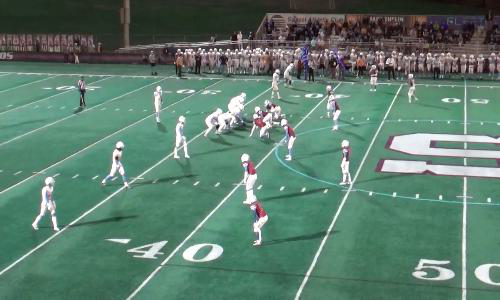

In [4]:
data_dir = '../football/'
data_dir = pathlib.Path(data_dir)
doubles = list(data_dir.glob('EmptyPictures/*.jpg'))
PIL.Image.open(str(doubles[5]))

## Step 3. Create Dataset using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

#### Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 224
img_width = 224
val_batches = batch_size

#### Create Train/Validation/Test (70%/10%/20%)
* It's good practice to use a validation split when developing your model. Also set aside test set for final accuracy report. 
* Use 70% of the images for training 10% for validation and 20% for test.

In [6]:
val_split= 0.3

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

print()
print("Train, Validation, Test dataset batch size: ")
for ds in [train_ds, val_ds, test_ds]:
    print(len(list(ds)))
    # val_ds.cardinality().numpy()

Found 1997 files belonging to 3 classes.
Using 1398 files for training.


2022-12-29 20:25:11.265976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1997 files belonging to 3 classes.
Using 599 files for validation.

Train, Validation, Test dataset batch size: 
44
7
12


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [7]:
class_names = train_ds.class_names
print(class_names)

['DoublesPictures', 'EmptyPictures', 'ReoPictures']


## Visualize the data

Here are the first 16 images from the training dataset:

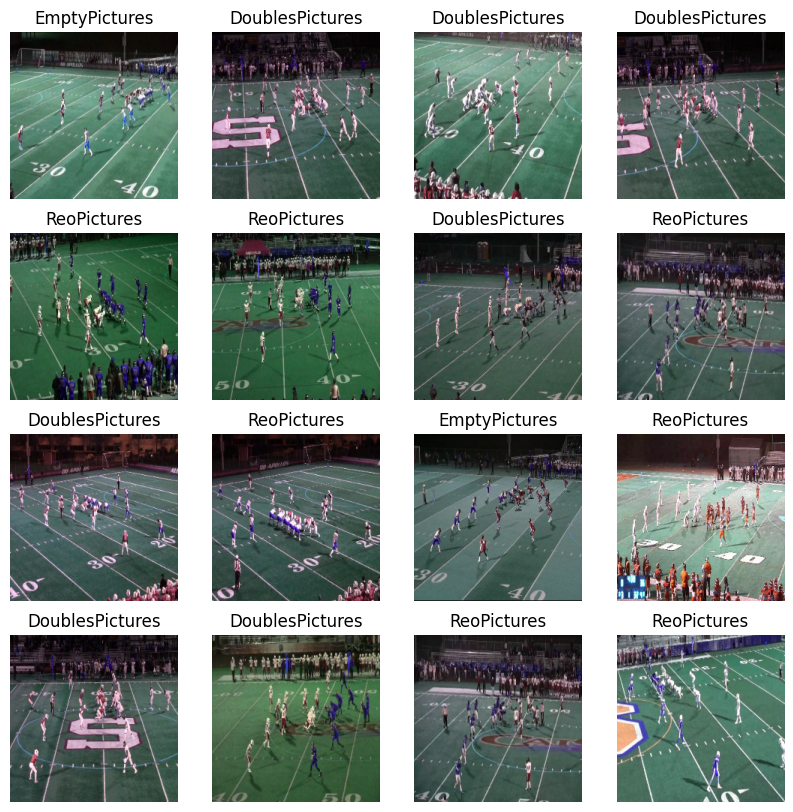

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 224, 224, 3)`. This is a batch of 32 images of shape `224x224x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [11]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.002180912 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. We use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## Step 4. Train 3 different models. Compare the results


## Step 4.1. First Model: Train a Keras CNN model from scratch

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

#### Notice the total parameters are ~6.4M of which all are trainable. 

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
44/44 [==============================] - 32s 700ms/step - loss: 1.0437 - accuracy: 0.4936 - val_loss: 0.8789 - val_accuracy: 0.5070
Epoch 2/10
44/44 [==============================] - 28s 632ms/step - loss: 0.7712 - accuracy: 0.6359 - val_loss: 0.6371 - val_accuracy: 0.7302
Epoch 3/10
44/44 [==============================] - 34s 778ms/step - loss: 0.4032 - accuracy: 0.8512 - val_loss: 0.5557 - val_accuracy: 0.7442
Epoch 4/10
44/44 [==============================] - 25s 575ms/step - loss: 0.1262 - accuracy: 0.9621 - val_loss: 0.3254 - val_accuracy: 0.9116
Epoch 5/10
44/44 [==============================] - 25s 573ms/step - loss: 0.0269 - accuracy: 0.9921 - val_loss: 0.2898 - val_accuracy: 0.9023
Epoch 6/10
44/44 [==============================] - 25s 575ms/step - loss: 0.0101 - accuracy: 0.9979 - val_loss: 0.2409 - val_accuracy: 0.9209
Epoch 7/10
44/44 [==============================] - 25s 567ms/step - loss: 0.0058 - accuracy: 0.9993 - val_loss: 0.2220 - val_accuracy: 0.9395

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

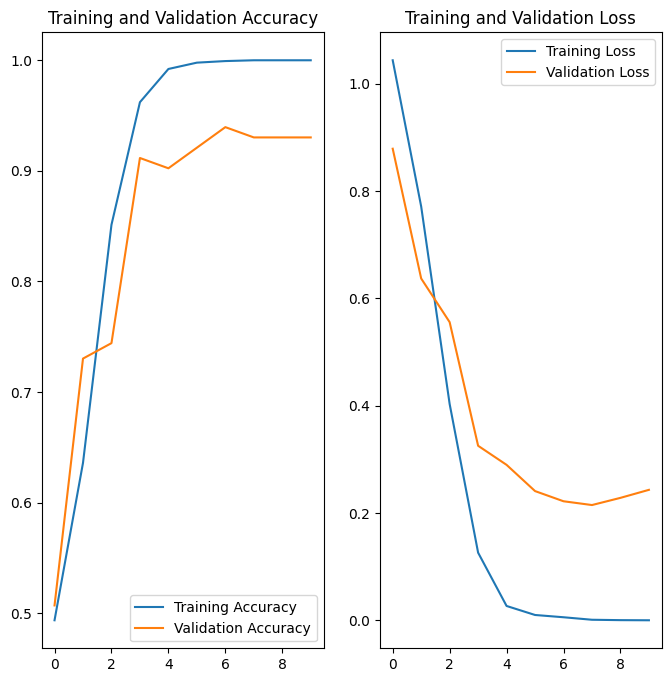

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis

* The plots show that training accuracy achieves 100% while validation accuracy are >95%
* The model overfits a bit and we can use techniques such as dropout, data augumentation, regulation, etc. to improve generalization

### Using trained model to predict on test dataset - Calculate the accuracy and classification report

In [18]:
# the scaling layer is in the model, so don't need to scale the data

cnt = 0
acc = 0

#predict_a = np.array()

i = 0
for test_data, test_label in test_ds:
    predictions = model.predict(test_data, verbose=False)
    predict = np.argmax(predictions, axis=-1)
    if i==0:
        predict_a = predict
        label_a = test_label.numpy()
    else:
        predict_a = np.concatenate((predict_a, predict))
        label_a = np.concatenate((label_a, test_label.numpy()))

    cnt += test_data.shape[0]
    acc += (predict==(test_label.numpy())).sum()

    i+=1
    
print(classification_report(label_a, predict_a, target_names=class_names))
print(f'total: {cnt}, correct: {acc}, accurate: {acc/cnt}')

                 precision    recall  f1-score   support

DoublesPictures       0.92      0.92      0.92       149
  EmptyPictures       1.00      0.91      0.95        46
    ReoPictures       0.93      0.95      0.94       189

       accuracy                           0.93       384
      macro avg       0.95      0.93      0.94       384
   weighted avg       0.93      0.93      0.93       384

total: 384, correct: 358, accurate: 0.9322916666666666


In [19]:
if not os.path.isdir('./saved_model'):
    os.mkdir('./saved_model')
model.save('saved_model/cnn_model')

# to load the model
# cnn_model = tf.keras.models.load_model('saved_model/cnn_model')

# Check its architecture
# cnn_model.summary()

#### Randomly pick some of the images from three formations and run the model prediction.


In [20]:
play_dic={}
play_dic[0] = 'Doubles'
play_dic[1] = 'Empty'
play_dic[2] = 'Reo'


for _ in range(20):
    
    ri = np.random.randint(0, 3)
    
    pic_n = np.random.randint(0, 50)
    #pic_n1 = np.random.randint(0, 4)
    
    print(play_dic[ri])
    
    image_url = "./football/" + play_dic[ri]+'Pictures/'+play_dic[ri]+'_'+str(pic_n)+'0.jpg'
    
    if not os.path.exists(image_url):
        continue
    
    print(image_url)
    img = tf.keras.utils.load_img(
        image_url, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

Reo
Reo
Empty
Doubles
Reo
Doubles
Empty
Doubles
Empty
Empty
Reo
Reo
Reo
Reo
Empty
Empty
Reo
Reo
Empty
Reo


## Step 4.2. Second Model - Pre-trained Mobilenet_v2 feature vector plus two fully-connected layers

### Use transfer learning technique to take advantage of pre-trained model from tensorflow_hub. 

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [21]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
# efficientnet_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"
# efficientnet_v2 ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"
# vit_s16 = "https://tfhub.dev/sayakpaul/vit_s16_classification/1"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [22]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_height, img_width, 3),
    trainable=False)


model_mobilenet = tf.keras.Sequential([
  #data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  feature_extractor_layer,
  tf.keras.layers.Dense(2048, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])

model_mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 2048)              2623488   
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 4,887,619
Trainable params: 2,629,635
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model_mobilenet.compile(
  optimizer='adam', #tf.keras.optimizers.Adam(learning_rate=0.0005),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [24]:
NUM_EPOCHS = 20
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_mobilenet = model_mobilenet.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=earlystop_callback)

Epoch 1/20
44/44 [==============================] - 31s 630ms/step - loss: 1.2638 - acc: 0.5594 - val_loss: 0.6510 - val_acc: 0.7070
Epoch 2/20
44/44 [==============================] - 27s 617ms/step - loss: 0.5927 - acc: 0.7282 - val_loss: 0.5727 - val_acc: 0.7674
Epoch 3/20
44/44 [==============================] - 27s 608ms/step - loss: 0.4569 - acc: 0.8069 - val_loss: 0.4872 - val_acc: 0.7907
Epoch 4/20
44/44 [==============================] - 26s 600ms/step - loss: 0.3463 - acc: 0.8648 - val_loss: 0.4140 - val_acc: 0.8233
Epoch 5/20
44/44 [==============================] - 27s 611ms/step - loss: 0.2383 - acc: 0.9235 - val_loss: 0.5418 - val_acc: 0.7721
Epoch 6/20
44/44 [==============================] - 27s 611ms/step - loss: 0.1961 - acc: 0.9335 - val_loss: 0.2850 - val_acc: 0.9070
Epoch 7/20
44/44 [==============================] - 27s 606ms/step - loss: 0.1296 - acc: 0.9707 - val_loss: 0.3990 - val_acc: 0.8000
Epoch 8/20
44/44 [==============================] - 28s 633ms/step - 

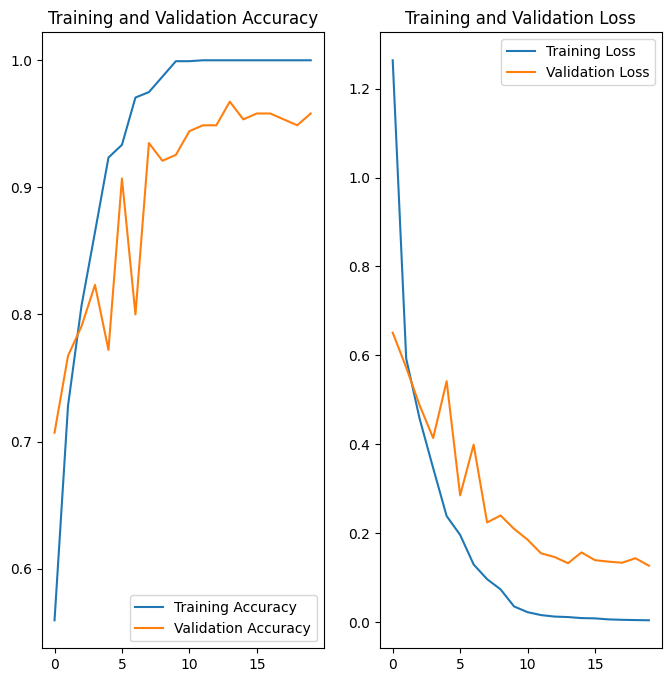

In [25]:
acc = history_mobilenet.history['acc']
val_acc = history_mobilenet.history['val_acc']

loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# the scaling layer is in the model, so don't need to scale the data

# normalization_layer = tf.keras.layers.Rescaling(1./255)
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

cnt = 0
acc = 0

#predict_a = np.array()

i = 0
for test_data, test_label in test_ds:
    predictions = model_mobilenet.predict(test_data, verbose=False)
    #print(predictions)
    score = tf.nn.softmax(predictions, axis=-1)
    predict = np.argmax(score, axis=-1)
    if i==0:
        predict_a = predict
        label_a = test_label.numpy()
    else:
        predict_a = np.concatenate((predict_a, predict))
        label_a = np.concatenate((label_a, test_label.numpy()))
    #print(predict.shape)
    cnt += test_data.shape[0]
    acc += (predict==(test_label.numpy())).sum()
    # print(test_label)
    # print(predict)
    i+=1
    
print(classification_report(label_a, predict_a, target_names=class_names))
print(f'total: {cnt}, correct: {acc}, accurate: {acc/cnt}')

                 precision    recall  f1-score   support

DoublesPictures       0.94      0.94      0.94       157
  EmptyPictures       0.93      0.91      0.92        43
    ReoPictures       0.96      0.96      0.96       184

       accuracy                           0.95       384
      macro avg       0.94      0.94      0.94       384
   weighted avg       0.95      0.95      0.95       384

total: 384, correct: 364, accurate: 0.9479166666666666


In [27]:
model_mobilenet.save('saved_model/mobilenet_model')

# to load the model
# model_mobilenet = tf.keras.models.load_model('saved_model/mobilenet_model')

# Check its architecture
# model_mobilenet.summary()

## Step 4.3.  Third Model - Pre-trained vit_s16 feature vector plus two fully-connected layers

### Vision Transformer (ViT): https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html

* Transformer based architecture for vision classification

In [28]:
vit_s16 = "https://tfhub.dev/sayakpaul/vit_s16_fe/1"
# vit_b32 = "https://tfhub.dev/sayakpaul/vit_b32_fe/1"

feature_extractor_model = vit_s16 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_height, img_width, 3),
    trainable=False)

feature_batch = feature_extractor_layer(image_batch)
print(f"Feature vector shape: {feature_batch.shape}")

2022-12-29 20:39:25.576407: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb122628e00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-12-29 20:39:25.577193: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-12-29 20:39:25.578461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 20:39:25.768321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-29 20:39:30.327267: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logge

Feature vector shape: (32, 384)


In [29]:
model_vit = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  feature_extractor_layer,
  
  tf.keras.layers.Dense(8096, activation='relu'),

  tf.keras.layers.Dense(num_classes)
])

model_vit.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 384)               21665664  
                                                                 
 dense_4 (Dense)             (None, 8096)              3116960   
                                                                 
 dense_5 (Dense)             (None, 3)                 24291     
                                                                 
Total params: 24,806,915
Trainable params: 3,141,251
Non-trainable params: 21,665,664
_________________________________________________________________


### With two fully connected layer on top of pre-trained feature extraction (ViT) the model has more than 3M trainable parameters. 

In [30]:
model_vit.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [31]:
NUM_EPOCHS = 20
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_vit = model_vit.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=earlystop_callback)

Epoch 1/20
44/44 [==============================] - 127s 3s/step - loss: 3.4181 - acc: 0.4721 - val_loss: 0.9154 - val_acc: 0.5488
Epoch 2/20
44/44 [==============================] - 103s 2s/step - loss: 0.7150 - acc: 0.6423 - val_loss: 0.7584 - val_acc: 0.6093
Epoch 3/20
44/44 [==============================] - 103s 2s/step - loss: 0.6188 - acc: 0.7067 - val_loss: 0.6209 - val_acc: 0.7209
Epoch 4/20
44/44 [==============================] - 103s 2s/step - loss: 0.5610 - acc: 0.7418 - val_loss: 0.6700 - val_acc: 0.6326
Epoch 5/20
44/44 [==============================] - 102s 2s/step - loss: 0.5431 - acc: 0.7532 - val_loss: 0.7146 - val_acc: 0.6326
Epoch 6/20
44/44 [==============================] - 114s 3s/step - loss: 0.4784 - acc: 0.7847 - val_loss: 0.4901 - val_acc: 0.8000
Epoch 7/20
44/44 [==============================] - 102s 2s/step - loss: 0.4274 - acc: 0.8205 - val_loss: 0.5199 - val_acc: 0.7395
Epoch 8/20
44/44 [==============================] - 103s 2s/step - loss: 0.3654 - a

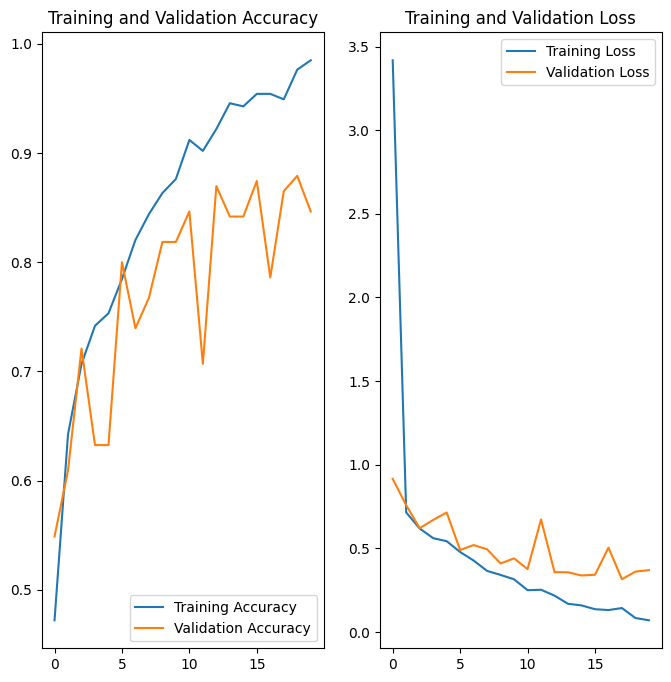

In [32]:
acc = history_vit.history['acc']
val_acc = history_vit.history['val_acc']

loss = history_vit.history['loss']
val_loss = history_vit.history['val_loss']

epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# the scaling layer is in the model, so don't need to scale the data

# normalization_layer = tf.keras.layers.Rescaling(1./255)
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

cnt = 0
acc = 0

#predict_a = np.array()

i = 0
for test_data, test_label in test_ds:
    predictions = model_vit.predict(test_data, verbose=False)

    predict = np.argmax(predictions, axis=-1)
    if i==0:
        predict_a = predict
        label_a = test_label.numpy()
    else:
        predict_a = np.concatenate((predict_a, predict))
        label_a = np.concatenate((label_a, test_label.numpy()))
    
    cnt += test_data.shape[0]
    acc += (predict==(test_label.numpy())).sum()

    i+=1
    
print(classification_report(label_a, predict_a, target_names=class_names))
print(f'total: {cnt}, correct: {acc}, accurate: {acc/cnt}')

                 precision    recall  f1-score   support

DoublesPictures       0.74      0.91      0.81       158
  EmptyPictures       0.86      0.67      0.76        46
    ReoPictures       0.91      0.78      0.84       180

       accuracy                           0.82       384
      macro avg       0.84      0.79      0.80       384
   weighted avg       0.83      0.82      0.82       384

total: 384, correct: 315, accurate: 0.8203125


In [34]:
model_vit.save('saved_model/model_vit')

# to load the model
# model_vit = tf.keras.models.load_model('saved_model/model_vit')

# Check its architecture
# model_vit.summary()

### Analysis
* Test Accuracy is ~85% which is less than CNN based model. Suspect it is due to limited data (less than 1400 images). Transformer based architecture is known to be data hungry and more data will certainly make this model better. 